# Sktime workshop: Pycon Colombia 2025 (Part 2)

![](imgs/sktime-logo.png)

2. **Forecasting panel data with sktime** (30 min)
   1. Data representation for panel data
   2. Upcasting feature in sktime
   3. Probabilistic forecasting
   4. Panel forecasting with Machine Learning models


## 2.1. Loading the data

In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

/var/folders/_2/9y4tsvdd2n3gqjgd2zmlr1km0000gn/T/ipykernel_29827/582074409.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from pycon_workshop.dataset import PyConWorkshopDataset

dataset = PyConWorkshopDataset("panel")

y_train, y_test, X_train, X_test = dataset.load("y_train", "y_test", "X_train", "X_test")

display(y_train)

sales
sku_id date             
0      2020-01-01      0
       2020-01-02      0
       2020-01-03      0
       2020-01-04      2
       2020-01-05      6
...                  ...
24     2024-07-01    200
       2024-07-02    184
       2024-07-03    164
       2024-07-04    202
       2024-07-05    142

[41200 rows x 1 columns]

In [3]:
display(X_train)

promo
sku_id date             
0      2020-01-01    0.0
       2020-01-02    0.0
       2020-01-03    0.0
       2020-01-04    0.0
       2020-01-05    0.0
...                  ...
24     2024-07-01    1.0
       2024-07-02    0.0
       2024-07-03    0.0
       2024-07-04    0.0
       2024-07-05    0.0

[41200 rows x 1 columns]

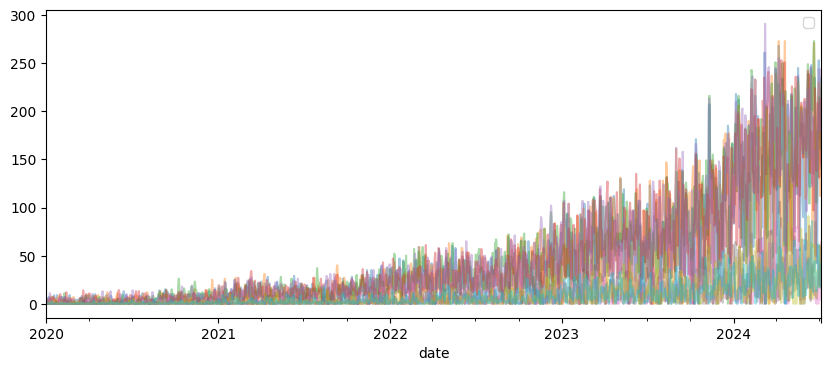

In [4]:
from sktime.utils.plotting import plot_series

fig, ax = plt.subplots(figsize=(10, 4))
y_train.unstack(level=0).droplevel(0, axis=1).iloc[:, :10].plot(ax=ax, alpha=0.4)
ax.legend([])
plt.show()

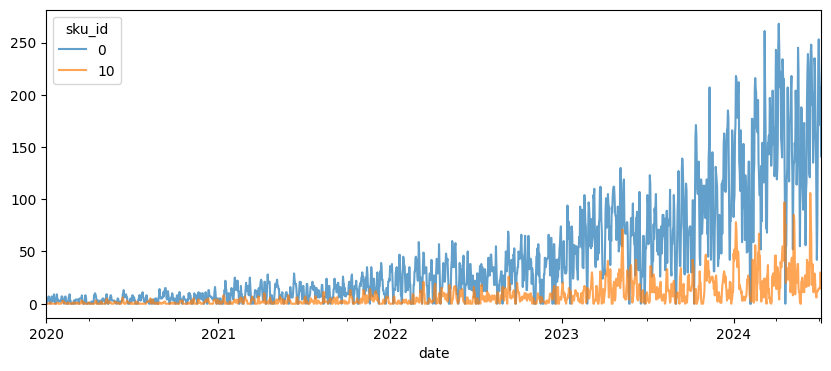

In [5]:
from sktime.utils.plotting import plot_series

fig, ax = plt.subplots(figsize=(10, 4))
y_train.unstack(level=0).droplevel(0, axis=1).iloc[:, [0,10]].plot(ax=ax, alpha=0.7)
plt.show()

#### 2.1.1. Pandas for multiindex data

To work with such data structures, it is important to revisit some pandas operations.

In [6]:
y_train.index.get_level_values(-1)


PeriodIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
             '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
             '2020-01-09', '2020-01-10',
             ...
             '2024-06-26', '2024-06-27', '2024-06-28', '2024-06-29',
             '2024-06-30', '2024-07-01', '2024-07-02', '2024-07-03',
             '2024-07-04', '2024-07-05'],
            dtype='period[D]', name='date', length=41200)

In pandas, the following operations are useful:

In [7]:
y_train.index

MultiIndex([( 0, '2020-01-01'),
            ( 0, '2020-01-02'),
            ( 0, '2020-01-03'),
            ( 0, '2020-01-04'),
            ( 0, '2020-01-05'),
            ( 0, '2020-01-06'),
            ( 0, '2020-01-07'),
            ( 0, '2020-01-08'),
            ( 0, '2020-01-09'),
            ( 0, '2020-01-10'),
            ...
            (24, '2024-06-26'),
            (24, '2024-06-27'),
            (24, '2024-06-28'),
            (24, '2024-06-29'),
            (24, '2024-06-30'),
            (24, '2024-07-01'),
            (24, '2024-07-02'),
            (24, '2024-07-03'),
            (24, '2024-07-04'),
            (24, '2024-07-05')],
           names=['sku_id', 'date'], length=41200)

In [8]:
y_train.index.get_level_values(0).unique()

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24],
      dtype='int64', name='sku_id')

In [9]:
y_train.loc[0]

,sales
date,
2020-01-01,0
2020-01-02,0
2020-01-03,0
2020-01-04,2
2020-01-05,6
...,...
2024-07-01,226
2024-07-02,212
2024-07-03,171


In [10]:
y_train.loc[pd.IndexSlice[[0,2], :]]

sales
sku_id date             
0      2020-01-01      0
       2020-01-02      0
       2020-01-03      0
       2020-01-04      2
       2020-01-05      6
...                  ...
2      2024-07-01    215
       2024-07-02    188
       2024-07-03    161
       2024-07-04    211
       2024-07-05    234

[3296 rows x 1 columns]

In [11]:
fh = y_test.index.get_level_values(1).unique()

In [12]:
fh

PeriodIndex(['2024-07-06', '2024-07-07', '2024-07-08', '2024-07-09',
             '2024-07-10', '2024-07-11', '2024-07-12', '2024-07-13',
             '2024-07-14', '2024-07-15',
             ...
             '2024-12-23', '2024-12-24', '2024-12-25', '2024-12-26',
             '2024-12-27', '2024-12-28', '2024-12-29', '2024-12-30',
             '2024-12-31', '2025-01-01'],
            dtype='period[D]', name='date', length=180)

## 2.2. Automatic upcasting

Have you ever dreamed of a world that you do not need to change code to switch between univariate and panel data?

**No extra lines needed!** Automatically upcast to panel data when using `sktime` estimators.

In [13]:
from sktime.forecasting.naive import NaiveForecaster


naive_forecaster = NaiveForecaster(strategy="last", window_length=1)
naive_forecaster.fit(y_train)
y_pred_naive = naive_forecaster.predict(fh=fh)

y_pred_naive

sales
sku_id date             
0      2024-07-06  141.0
       2024-07-07  141.0
       2024-07-08  141.0
       2024-07-09  141.0
       2024-07-10  141.0
...                  ...
24     2024-12-28  142.0
       2024-12-29  142.0
       2024-12-30  142.0
       2024-12-31  142.0
       2025-01-01  142.0

[4500 rows x 1 columns]

* Internally, sktime creates one clone of the estimator for each series in the panel data
* Then it fits each clone to the corresponding series.

In [14]:
naive_forecaster.forecasters_.head()

,forecasters
0,NaiveForecaster(window_length=1)
1,NaiveForecaster(window_length=1)
2,NaiveForecaster(window_length=1)
3,NaiveForecaster(window_length=1)
4,NaiveForecaster(window_length=1)


**This is extremely useful for clean code and rapid prototyping!**


Now that we have multiple series, we need to explain to the metric how to handle this!

* Use `multilevel="uniform_average_time"` to average the time series across the panel.
* Use `multilevel="raw_values"` to obtain the error per series.

In [15]:
from sktime.performance_metrics.forecasting import MeanSquaredScaledError

metric = MeanSquaredScaledError(multilevel="uniform_average_time")

In [16]:
metric(y_true=y_test, y_pred=y_pred_naive, y_train=y_train)

18.808114392513442

## 2.3. Machine learning models for timeseries forecasting

* We can apply ML Regressors to time series forecasting.
* We call this process **reduction**
 
![](imgs/global_reduction.png)

The `WindowSummarizer` creates the set of temporal tabular features for the ML model.

In [17]:
from sktime.transformations.series.summarize import WindowSummarizer

summarizer = WindowSummarizer(
    lag_feature={
        "lag" : list(range(1,20)),
        "std" : [list(range(1,20))],
    },
)

summarizer.fit_transform(y_train, X_train)


sales_lag_1  sales_lag_18  sales_lag_17  sales_lag_16  \
sku_id date                                                                
0      2020-01-01          NaN           NaN           NaN           NaN   
       2020-01-02          0.0           NaN           NaN           NaN   
       2020-01-03          0.0           NaN           NaN           NaN   
       2020-01-04          0.0           NaN           NaN           NaN   
       2020-01-05          2.0           NaN           NaN           NaN   
...                        ...           ...           ...           ...   
24     2024-07-01        222.0         136.0          68.0         139.0   
       2024-07-02        200.0          68.0         139.0         139.0   
       2024-07-03        184.0         139.0         139.0         211.0   
       2024-07-04        164.0         139.0         211.0         240.0   
       2024-07-05        202.0         211.0         240.0         233.0   

                   sales_lag_15  sales_lag_14  sales_lag_13  sales_lag_12  \
sku_id date                                                                 
0      2020-01-01           NaN           NaN           NaN           NaN   
       2020-01-02           NaN           NaN           NaN           NaN   
       2020-01-03           NaN           NaN           NaN           NaN   
       2020-01-04           NaN           NaN           NaN           NaN   
       2020-01-05           NaN           NaN           NaN           NaN   
...                         ...           ...           ...           ...   
24     2024-07-01         139.0         211.0         240.0         233.0   
       2024-07-02         211.0         240.0         233.0         266.0   
       2024-07-03         240.0         233.0         266.0         234.0   
       2024-07-04         233.0         266.0         234.0         260.0   
       2024-07-05         266.0         234.0         260.0         195.0   

                   sales_lag_11  sales_lag_19  sales_lag_9  sales_lag_8  \
sku_id date                                                               
0      2020-01-01           NaN           NaN          NaN          NaN   
       2020-01-02           NaN           NaN          NaN          NaN   
       2020-01-03           NaN           NaN          NaN          NaN   
       2020-01-04           NaN           NaN          NaN          NaN   
       2020-01-05           NaN           NaN          NaN          NaN   
...                         ...           ...          ...          ...   
24     2024-07-01         266.0         123.0        260.0        195.0   
       2024-07-02         234.0         136.0        195.0        181.0   
       2024-07-03         260.0          68.0        181.0        143.0   
       2024-07-04         195.0         139.0        143.0        161.0   
       2024-07-05         181.0         139.0        161.0        173.0   

                   sales_lag_10  sales_lag_6  sales_lag_2  sales_lag_5  \
sku_id date                                                              
0      2020-01-01           NaN          NaN          NaN          NaN   
       2020-01-02           NaN          NaN          NaN          NaN   
       2020-01-03           NaN          NaN          0.0          NaN   
       2020-01-04           NaN          NaN          0.0          NaN   
       2020-01-05           NaN          NaN          0.0          NaN   
...                         ...          ...          ...          ...   
24     2024-07-01         234.0        143.0        204.0        161.0   
       2024-07-02         260.0        161.0        222.0        173.0   
       2024-07-03         195.0        173.0        200.0        188.0   
       2024-07-04         181.0        188.0        184.0        204.0   
       2024-07-05         143.0        204.0        164.0        222.0   

                   sales_lag_3  sales_lag_4  sales_lag_7  \
sku_id date                  

* How to compute forecasts for multiple steps ahead?
* We can use two approaches:
  * `RecursiveTabularRegressionForecaster`: recursively predicts the next value and uses it as input for the next prediction.
  * `DirectTabularRegressionForecaster`: creates a separate model for each step ahead.

In [18]:
from sktime.forecasting.compose import RecursiveTabularRegressionForecaster
from sklearn.ensemble import RandomForestRegressor

global_forecaster1 = RecursiveTabularRegressionForecaster(
    RandomForestRegressor(n_estimators=20, random_state=42),
    pooling="global",
    window_length=None,
    transformers=[summarizer]
)

global_forecaster1.fit(y_train, X_train)

RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(n_estimators=20, random_state=42),
                                     pooling='global',
                                     transformers=[WindowSummarizer(lag_feature={'lag': [1,
                                                                                         2,
                                                                                         3,
                                                                                         4,
                                                                                         5,
                                                                                         6,
                                                                                         7,
                                                                                         8,
                                                                                         9,
                                                                                         10,
                                                                                         11,
                                                                                         12,
                                                                                         13,
                                                                                         14,
                                                                                         15,
                                                                                         16,
                                                                                         17,
                                                                                         18,
                                                                                         19],
                                                                                 'std': [[1,
                                                                                          2,
                                                                                          3,
                                                                                          4,
                                                                                          5,
                                                                                          6,
                                                                                          7,
                                                                                          8,
                                                                                          9,
                                                                                          10,
                                                                                          11,
                                                                                          12,
                                                                                          13,
                                                                                          14,
                                                                                          15,
                                                                                          16,
                                                                                          17,
                                                                                          18,
                                                                                          19]]})],
                                     window_length=None)

In [19]:
global_forecaster1.get_params()

{'estimator': RandomForestRegressor(n_estimators=20, random_state=42),
 'pooling': 'global',
 'transformers': [WindowSummarizer(lag_feature={'lag': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                        14, 15, 16, 17, 18, 19],
                                'std': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19]]})],
 'window_length': None,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'squared_error',
 'estimator__max_depth': None,
 'estimator__max_features': 1.0,
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__monotonic_cst': None,
 'estimator__n_estimators': 20,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': 42,
 'estimator_

In [20]:
y_pred_global1 = global_forecaster1.predict(fh=fh, X=X_test)

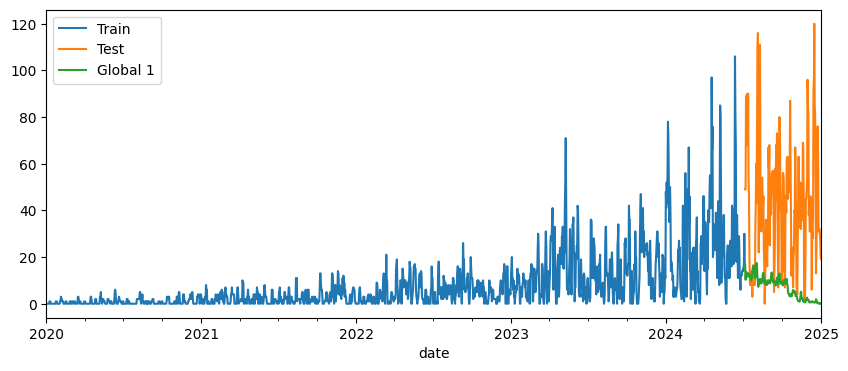

In [21]:
fig, ax = plt.subplots(figsize=(10, 4))
y_train.loc[10, "sales"].plot(ax=ax, label="Train")
y_test.loc[10, "sales"].plot(ax=ax, label="Test")
y_pred_global1.loc[10, "sales"].plot(ax=ax, label="Global 1")
plt.legend()
plt.show()

### Feature engineering is important!

* We should not think that ML models learn everything by themselves.
* We have to think as they think. They see values, not time series.
* The **scale becomes a feature** that allows the model to identify which series is it forecasting.
* We can standardize the different series to make them comparable.

In [113]:
metric(y_true=y_test, y_pred=y_pred_global1, y_train=y_train)

25.21984648263027

In [114]:
from sklearn.preprocessing import StandardScaler


global_forecaster2 = StandardScaler() * global_forecaster1

global_forecaster2.fit(y_train, X_train)

TransformedTargetForecaster(steps=[TabularToSeriesAdaptor(transformer=StandardScaler()),
                                   RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(n_estimators=20, random_state=42),
                                                                        pooling='global',
                                                                        transformers=[WindowSummarizer(lag_feature={'lag': [1,
                                                                                                                            2,
                                                                                                                            3,
                                                                                                                            4,
                                                                                                                            5,
                                                                                                                            6,
                                                                                                                            7,
                                                                                                                            8,
                                                                                                                            9,
                                                                                                                            10,
                                                                                                                            11,
                                                                                                                            12,
                                                                                                                            13,
                                                                                                                            14,
                                                                                                                            15,
                                                                                                                            16,
                                                                                                                            17,
                                                                                                                            18,
                                                                                                                            19],
                                                                                                                    'std': [[1,
                                                                                                                             2,
                                                                                                                             3,
                                                                                                                             4,
                                                                                                                             5,
                                                                                                                             6,
                                                                                                                             7,
                                                                                                                             8,
                                                                                                                             9,
                                                                                                          

In [24]:
y_pred_global2 = global_forecaster2.predict(fh=fh, X=X_test)

In [25]:
metric(y_true=y_test, y_pred=y_pred_global2, y_train=y_train)

21.974657819047454

<Axes: xlabel='date'>

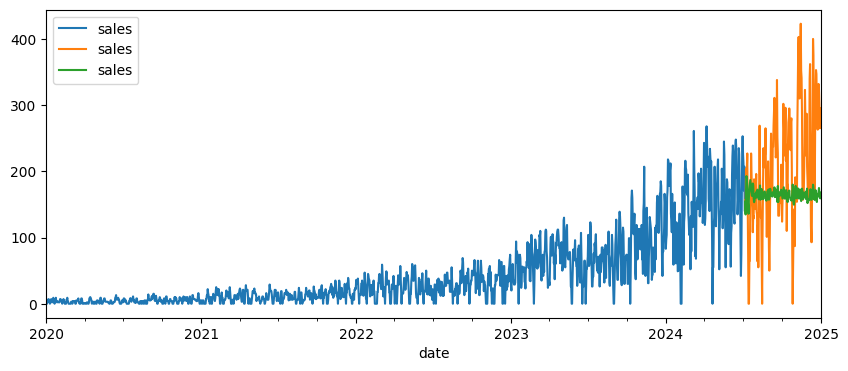

In [26]:
fig, ax = plt.subplots(figsize=(10, 4))
y_train.loc[0].plot(ax=ax, label="Train")
y_test.loc[0].plot(ax=ax, label="Test")
y_pred_global2.loc[0].plot(ax=ax, label="Global 1")

* Only scaling each timeseries allows the model to learn accross them...
* They cannot forecast out of the scale of the training data.
* How can 2022's and 2023's autoregressive behaviour be used together to enhance the model, without having the level as a feature?

In [27]:
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.boxcox import LogTransformer

global_forecaster3 = Differencer() * global_forecaster2
global_forecaster3.fit(y_train, X_train)

TransformedTargetForecaster(steps=[Differencer(),
                                   TabularToSeriesAdaptor(transformer=StandardScaler()),
                                   RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(n_estimators=20, random_state=42),
                                                                        pooling='global',
                                                                        transformers=[WindowSummarizer(lag_feature={'lag': [1,
                                                                                                                            2,
                                                                                                                            3,
                                                                                                                            4,
                                                                                                                            5,
                                                                                                                            6,
                                                                                                                            7,
                                                                                                                            8,
                                                                                                                            9,
                                                                                                                            10,
                                                                                                                            11,
                                                                                                                            12,
                                                                                                                            13,
                                                                                                                            14,
                                                                                                                            15,
                                                                                                                            16,
                                                                                                                            17,
                                                                                                                            18,
                                                                                                                            19],
                                                                                                                    'std': [[1,
                                                                                                                             2,
                                                                                                                             3,
                                                                                                                             4,
                                                                                                                             5,
                                                                                                                             6,
                                                                                                                             7,
                                                                                                                             8,
                                                                                                                             9,
                                                        

In [28]:
y_pred_global3 = global_forecaster3.predict(fh=fh, X=X_test)
metric(y_true=y_test, y_pred=y_pred_global3, y_train=y_train)

13.335553794511155

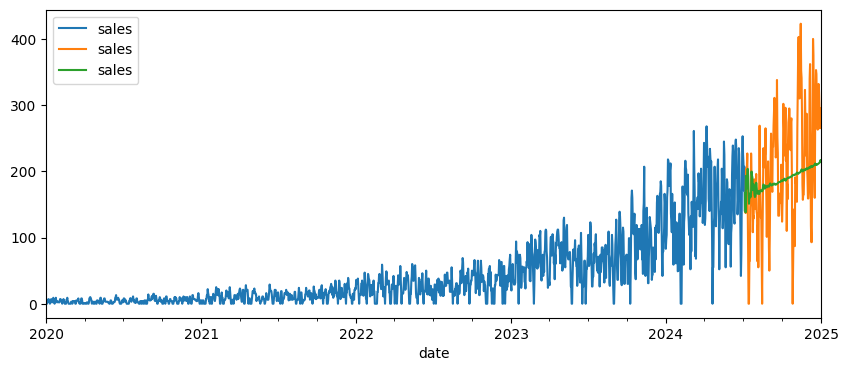

In [29]:
fig, ax = plt.subplots(figsize=(10, 4))
y_train.loc[0].plot(ax=ax, label="Train")
y_test.loc[0].plot(ax=ax, label="Test")
y_pred_global3.loc[0].plot(ax=ax, label="Global 4")
fig.show()

### Exogenous pipelines also for panel data!


In [30]:
from sktime.transformations.series.fourier import FourierFeatures

fourier_features = FourierFeatures(sp_list=[365.25, 365.25/12], fourier_terms_list=[1, 1], freq="D")

global_forecaster4 = fourier_features ** global_forecaster3
global_forecaster4.fit(y_train, X_train)

ForecastingPipeline(steps=[FourierFeatures(fourier_terms_list=[1, 1], freq='D',
                                           sp_list=[365.25, 30.4375]),
                           TransformedTargetForecaster(steps=[Differencer(),
                                                              TabularToSeriesAdaptor(transformer=StandardScaler()),
                                                              RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(n_estimators=20, random_state=42),
                                                                                                   pooling='global',
                                                                                                   transformers=[WindowSummarizer(lag_feature={'lag': [1,
                                                                                                                                                       2,
                                                                                                                                                       3,
                                                                                                                                                       4,
                                                                                                                                                       5,
                                                                                                                                                       6,
                                                                                                                                                       7,
                                                                                                                                                       8,
                                                                                                                                                       9,
                                                                                                                                                       10,
                                                                                                                                                       11,
                                                                                                                                                       12,
                                                                                                                                                       13,
                                                                                                                                                       14,
                                                                                                                                                       15,
                                                                                                                                                       16,
                                                                                                                                                       17,
                                                                                                                                                       18,
                                                                                                                                                       19],
                                                                                                                                               'std': [[1,
                                                                                                                                                        2,
                                                                                                                              

In [31]:
y_pred_global4 = global_forecaster4.predict(fh=fh, X=X_test)
metric(y_true=y_test, y_pred=y_pred_global4, y_train=y_train)

14.911933033791668

In [32]:
metric(y_true=y_test, y_pred=y_pred_global4, y_train=y_train)

14.911933033791668

## 2.4. Probabilistic forecasting

When forecasting for retail, we often interested in the uncertainty of the forecasts.

* Safety stock
* Predict probability of stockouts

In [33]:
from sktime.registry import all_estimators

all_estimators("forecaster", filter_tags={"capability:pred_int": True}, as_dataframe=True)

,name,object
0,ARCH,<class 'sktime.forecasting.arch._uarch.ARCH'>
1,ARIMA,<class 'sktime.forecasting.arima._pmdarima.ARI...
2,AutoARIMA,<class 'sktime.forecasting.arima._pmdarima.Aut...
3,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
4,BATS,<class 'sktime.forecasting.bats.BATS'>
5,BaggingForecaster,<class 'sktime.forecasting.compose._bagging.Ba...
6,BoxCoxBiasAdjustedForecaster,<class 'sktime.forecasting.boxcox_bias_adjuste...
7,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...
8,ConformalIntervals,<class 'sktime.forecasting.conformal.Conformal...
9,DartsLinearRegressionModel,<class 'sktime.forecasting.darts.DartsLinearRe...


In [34]:
from sktime.forecasting.auto_reg import AutoREG
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.fourier import FourierFeatures
from sktime.forecasting.conformal import ConformalIntervals

fourier_features = FourierFeatures(
    sp_list=[365.25, 365.25 / 12], fourier_terms_list=[1, 1], freq="D"
)
auto_reg = fourier_features ** (Differencer() * AutoREG())


conformal_forecaster = ConformalIntervals(
    forecaster=auto_reg, initial_window=365 * 2, sample_frac=0.5
)

In [35]:
parallel_config = {
        "backend:parallel": "joblib",
        "backend:parallel:params": {"backend": "loky", "n_jobs": -1},
    }

conformal_forecaster.set_config(
    **parallel_config
)

conformal_forecaster.fit(y_train)

ConformalIntervals(forecaster=ForecastingPipeline(steps=[FourierFeatures(fourier_terms_list=[1,
                                                                                             1],
                                                                         freq='D',
                                                                         sp_list=[365.25,
                                                                                  30.4375]),
                                                         TransformedTargetForecaster(steps=[Differencer(),
                                                                                            AutoREG()])]),
                   initial_window=730, sample_frac=0.5)

In [130]:
y_pred_int = conformal_forecaster.predict_interval(fh=fh, coverage=0.9)

In [131]:
y_pred_int

sales            
                          0.9            
                        lower       upper
sku_id date                              
0      2024-07-06   70.823914  204.959221
       2024-07-07   61.566508  216.213483
       2024-07-08   71.861667  228.306023
       2024-07-09   71.913842  220.397269
       2024-07-10   70.720258  222.059785
...                       ...         ...
24     2024-12-28   97.869247  279.515236
       2024-12-29   99.543643  288.367163
       2024-12-30  100.442321  286.607292
       2024-12-31  105.610509  285.716061
       2025-01-01  108.582437  285.125478

[4500 rows x 2 columns]

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Panel data'}, ylabel='sales'>)

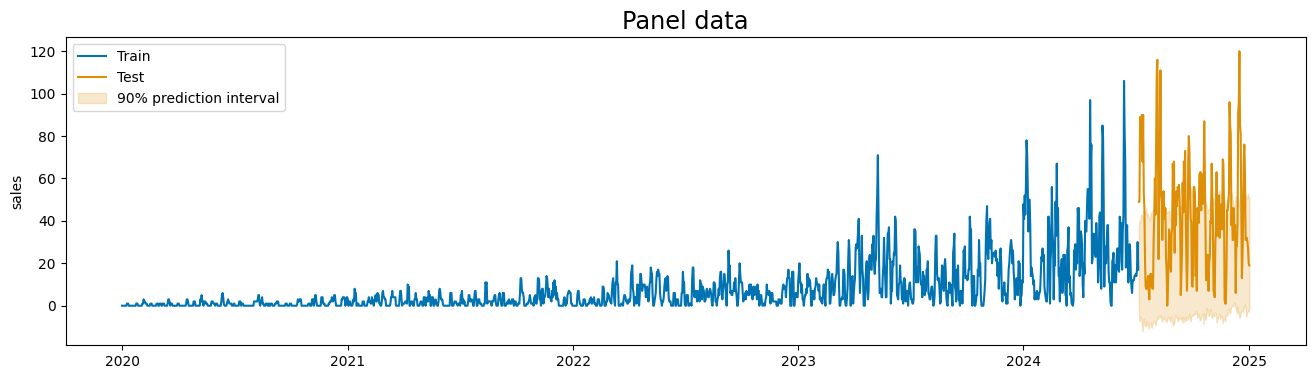

In [132]:
plot_series(
    y_train.loc[10], y_test.loc[10], labels=["Train", "Test"], title="Panel data",
    pred_interval=y_pred_int.loc[10], markers=[None]*2
)

There are negative values in the data, which do not make sense for our problem.

We can use a model that predicts a distribution that does not allow negative values, such as the **negative binomial distribution**.

In [133]:
from prophetverse import Prophetverse, PiecewiseLinearTrend, MAPInferenceEngine


prophet = Prophetverse(
    trend=PiecewiseLinearTrend(changepoint_interval=365),
    likelihood="negbinomial",
    inference_engine=MAPInferenceEngine()
)

prophet.set_config(
    **parallel_config
)

prophet.fit(y_train, X_train)

Prophetverse(inference_engine=MAPInferenceEngine(), likelihood='negbinomial',
             trend=PiecewiseLinearTrend(changepoint_interval=365))

In [134]:
y_pred_int_prophetverse = prophet.predict_interval(fh=fh, X=X_test, coverage=0.9)

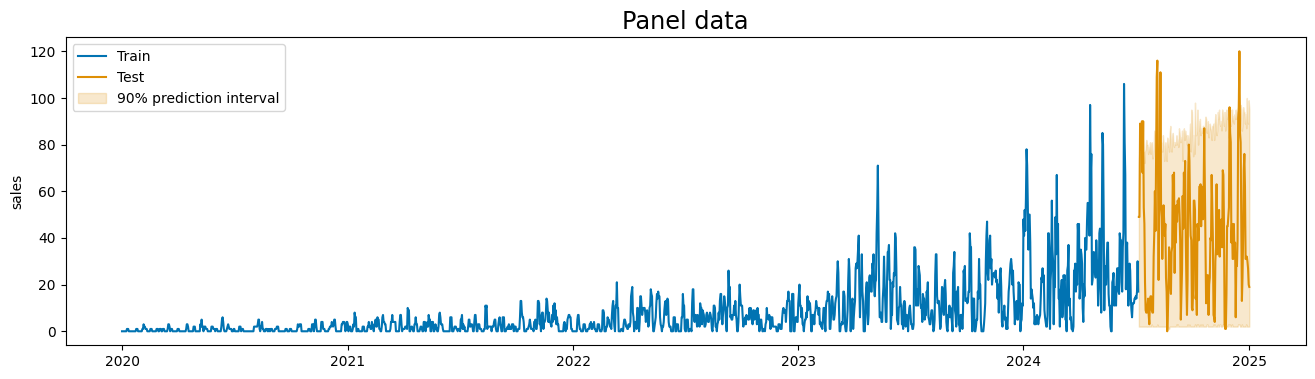

In [135]:
plot_series(
    y_train.loc[10], y_test.loc[10], labels=["Train", "Test"], title="Panel data",
    pred_interval=y_pred_int_prophetverse.loc[10], markers=[None]*2
)

plt.show()

### Example of metric for probabilistic forecasting

In [136]:
from sktime.performance_metrics.forecasting.probabilistic import PinballLoss

pinball_loss = PinballLoss()

pd.DataFrame(
    {"Conformal": pinball_loss(y_true=y_test, y_pred=y_pred_int),
     "Prophetverse Negbinomial": pinball_loss(y_true=y_test, y_pred=y_pred_int_prophetverse)},
    index=["Pinball Loss"]
)


,Conformal,Prophetverse Negbinomial
Pinball Loss,7.995371,5.440022


## 2.5. Deep learning models and zero-shot forecasting

* In addition to simple ML models, we can also use deep learning models for forecasting.
* There are some models with tailored architectures for time series forecasting.
* For example, N-BEATS is a deep learning model that can be used for forecasting.
  
* **Zero-shot forecasting** is extremely useful when a new product appears, a new warehouse... etc.
  
![](imgs/nbeats_simplified.png)

In [104]:
from sktime.forecasting.pytorchforecasting import PytorchForecastingNBeats
from pytorch_forecasting.data.encoders import EncoderNormalizer

CONTEXT_LENGTH = 365
nbeats = PytorchForecastingNBeats(
    train_to_dataloader_params={"batch_size": 256},
    trainer_params={"max_epochs": 1},
    model_params={
        "stack_types": ["trend", "seasonality"], # One of the following values: “generic”, “seasonality” or “trend”.
        "num_blocks" : [2,2], # The number of blocks per stack. 
        "context_length": CONTEXT_LENGTH, # lookback period
        "expansion_coefficient_lengths" : [2, 5],
        "learning_rate": 1e-3,
    },
    dataset_params={

        "max_encoder_length": CONTEXT_LENGTH,
        "target_normalizer": EncoderNormalizer()
    },
)

nbeats.fit(y_train.astype(float), fh=fh)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 1.6 M  | train
-------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.550     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 90/90 [00:04<00:00, 20.36it/s, v_num=68, train_loss_step=2.090, val_loss=2.070, train_loss_epoch=2.090]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 90/90 [00:04<00:00, 20.19it/s, v_num=68, train_loss_step=2.090, val_loss=2.070, train_loss_epoch=2.090]


PytorchForecastingNBeats(dataset_params={'max_encoder_length': 365,
                                         'target_normalizer': EncoderNormalizer(
	method='standard',
	center=True,
	max_length=None,
	transformation=None,
	method_kwargs={}
)},
                         model_params={'context_length': 365,
                                       'expansion_coefficient_lengths': [2, 5],
                                       'learning_rate': 0.001,
                                       'num_blocks': [2, 2],
                                       'stack_types': ['trend', 'seasonality']},
                         train_to_dataloader_params={'batch_size': 256},
                         trainer_params={'max_epochs': 1})

In [105]:
y_pred_nbeats = nbeats.predict(fh=fh, X=X_test)

/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:656: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _y.fillna(0, inplace=True)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [106]:
metric(y_true=y_test, y_pred=y_pred_nbeats, y_train=y_train)

10.79056795346621

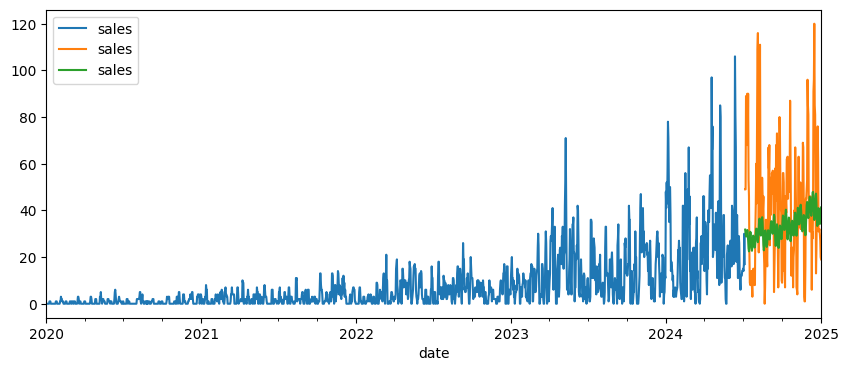

In [107]:
fig, ax = plt.subplots(figsize=(10, 4))
y_train.loc[10].plot(ax=ax, label="Train")
y_test.loc[10].plot(ax=ax, label="Test")
y_pred_nbeats.loc[10].plot(ax=ax, label="N-BEATS")
fig.show()

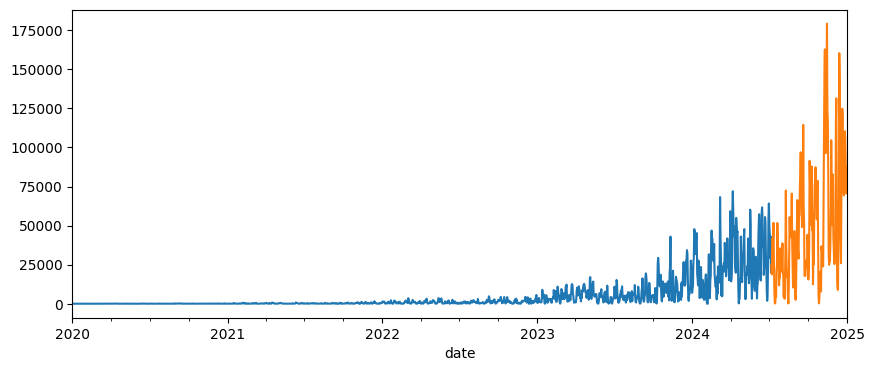

In [112]:
new_y_train = (y_train.loc[0]**2 + y_train.loc[20]).astype(float)
new_y_test = (y_test.loc[0]**2 + y_test.loc[20]).astype(float)

# Plotting the new series
fig, ax = plt.subplots(figsize=(10, 4))
new_y_train["sales"].plot.line(ax=ax, label="New Train")
new_y_test["sales"].plot.line(ax=ax, label="New Test")
fig.show()

In [109]:
y_pred_zeroshot = nbeats.predict(fh=fh, y=new_y_train)

/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:656: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _y.fillna(0, inplace=True)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


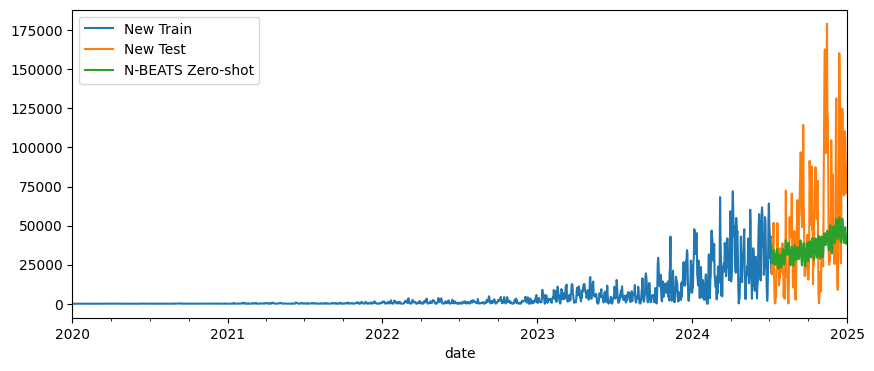

In [111]:
fig, ax = plt.subplots(figsize=(10, 4))
new_y_train["sales"].plot.line(ax=ax, label="New Train")
new_y_test["sales"].plot.line(ax=ax, label="New Test")
y_pred_zeroshot["sales"].plot.line(ax=ax, label="N-BEATS Zero-shot")
plt.legend()
plt.show()